# Setup
## Install dependencies
```console
$ pip install pymc3 theano seaborn jupyter pandas
```
## Get data
Download https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N8XJME and gunzip it.
## Extract relevant columns from first million data rows
```console
$ head -n1000000 settles.acl16.learning_traces.13m.csv | cut -d, -f3,9,10,11,12 > pymcmill.csv
```

In [1]:
%matplotlib inline
import numpy as np
import theano.tensor as tt
import pymc3 as pm

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

/Users/kamo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Running on PyMC3 v3.8


In [2]:
import pandas as pd
million = pd.read_csv("pymcmill.csv")
million['sqrtright']=np.sqrt(1+million.history_correct)
million['sqrtwrong']=np.sqrt(1+(million.history_seen - million.history_correct))
million['days']=million.delta/(3600*24)
data = million[:1000]
data

,delta,history_seen,history_correct,session_seen,session_correct,sqrtright,sqrtwrong,days
0,3065627,3,3,2,2,2.000000,1.000000,35.481794
1,335,266,256,2,2,16.031220,3.316625,0.003877
2,481,5,5,1,0,2.449490,1.000000,0.005567
3,336093,18,16,3,3,4.123106,1.732051,3.889965
4,411,150,136,1,1,11.704700,3.872983,0.004757
...,...,...,...,...,...,...,...,...
995,1366,6,6,1,1,2.645751,1.000000,0.015810
996,1806,3,3,4,4,2.000000,1.000000,0.020903
997,338,8,8,5,5,3.000000,1.000000,0.003912
998,14356,3,3,1,1,2.000000,1.000000,0.166157


# Try 1: use `shape=1` for the Beta distribution

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [p, wbeta, walpha]
Sampling 5 chains, 0 divergences: 100%|██████████| 10000/10000 [00:50<00:00, 199.46draws/s]
The acceptance probability does not match the target. It is 0.8880143318986359, but should be close to 0.8. Try to increase the number of tuning steps.
/Users/kamo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/kamo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/Users/kamo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has

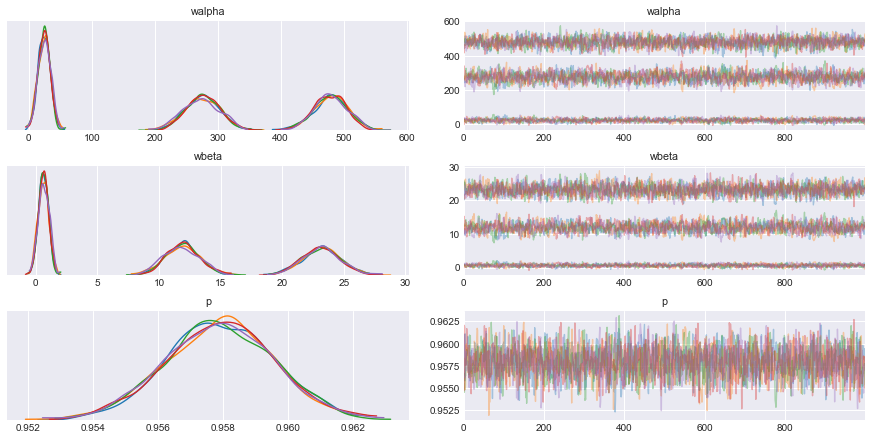

In [3]:
with pm.Model() as model:
    # weights
    walpha = pm.Normal('walpha', mu=10, sigma=30, shape=3)
    wbeta = pm.Normal('wbeta', mu=10, sigma=30, shape=3)
    
    # Ebisu-style variables
    alpha = (walpha[0] * data.sqrtright.values + walpha[1] * data.sqrtwrong.values + walpha[2]).clip(1, 3000)
    beta = (wbeta[0] * data.sqrtright.values + wbeta[1] * data.sqrtwrong.values + wbeta[2]).clip(1, 3000)

    p = pm.Beta('p', alpha=alpha, beta=beta, shape=1, testval=0.7)
    pt = p**data.days.values
    x = pm.Binomial('x', n=data.session_seen.values, p=pt, observed=data.session_correct.values)
    
    trace = pm.sample(1000, tune=1000, cores=5, progressbar=True)
pm.traceplot(trace);

In [4]:
final = pm.trace_to_dataframe(trace)

means = final.mean()
test = million[1000:20000]


alphas = (means.walpha__0 * test.sqrtright.values + means.walpha__1 * test.sqrtwrong.values + means.walpha__2).clip(1, np.inf)
betas = (means.wbeta__0 * test.sqrtright.values + means.wbeta__1 * test.sqrtwrong.values + means.wbeta__2).clip(1, np.inf)
from scipy.stats import beta

pts = []
for (idx,(a,b)) in enumerate(zip(alphas,betas)):
    b = beta(a,b)
    p = b.rvs(1000)
    pt = p**test.iloc[idx].days
    pts.append(np.mean(pt))
mae = np.mean(np.abs(np.array(pts) - (test.session_correct / test.session_seen).values))
print(mae)

final.describe()

0.21487476462084631


,walpha__0,walpha__1,walpha__2,wbeta__0,wbeta__1,wbeta__2,p__0
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,24.476473,275.787119,479.617431,0.626260,11.905685,23.192174,0.957889
std,9.610305,27.612764,26.642851,0.420487,1.402466,1.558425,0.001659
min,-5.305163,174.773742,386.854049,-0.845659,7.355126,18.147468,0.951917
25%,17.758980,256.882284,461.890010,0.346235,10.922559,22.137509,0.956792
50%,24.624460,275.883393,479.838922,0.623288,11.905573,23.214482,0.957901
75%,30.974987,295.235049,497.684291,0.912501,12.834215,24.210476,0.959030
max,58.364986,373.390135,574.661753,2.026899,17.017463,28.804461,0.963149


# Try 2: using `shape=len(data)` for Beta
*FIXME* almost exactly same code as above for the next two cells!
Much slower but more sensible?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [p, wbeta, walpha]
Sampling 5 chains, 6 divergences: 100%|██████████| 10000/10000 [47:46<00:00,  3.49draws/s]   
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6402527435370912, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/kamo/.pyenv/versions/3.8.1/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupp

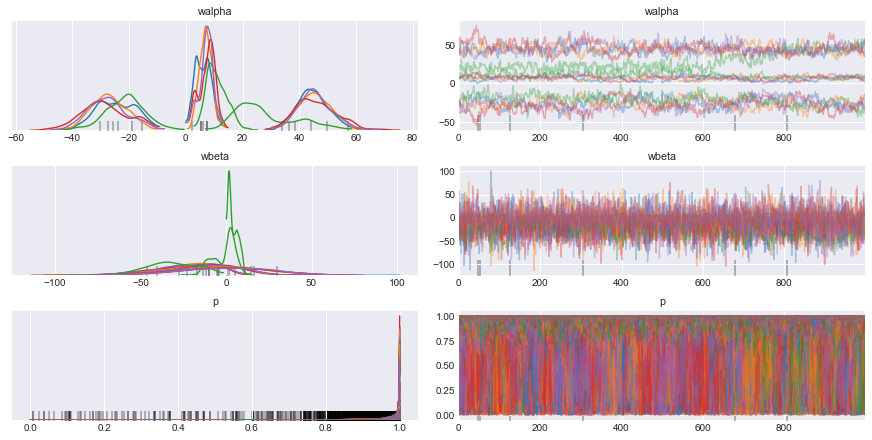

In [9]:
with pm.Model() as model:
    # weights
    walpha = pm.Normal('walpha', mu=10, sigma=30, shape=3)
    wbeta = pm.Normal('wbeta', mu=10, sigma=30, shape=3)
    
    # Ebisu-style variables
    alpha = (walpha[0] * data.sqrtright.values + walpha[1] * data.sqrtwrong.values + walpha[2]).clip(1, 3000)
    beta = (wbeta[0] * data.sqrtright.values + wbeta[1] * data.sqrtwrong.values + wbeta[2]).clip(1, 3000)

    p = pm.Beta('p', alpha=alpha, beta=beta, shape=len(data), testval=0.7)
    pt = p**data.days.values
    x = pm.Binomial('x', n=data.session_seen.values, p=pt, observed=data.session_correct.values)
    
    trace2 = pm.sample(1000, tune=1000, cores=5, progressbar=True)
pm.traceplot(trace2);

In [10]:
final = pm.trace_to_dataframe(trace2)

means = final.mean()
test = million[1000:20000]


alphas = (means.walpha__0 * test.sqrtright.values + means.walpha__1 * test.sqrtwrong.values + means.walpha__2).clip(1, np.inf)
betas = (means.wbeta__0 * test.sqrtright.values + means.wbeta__1 * test.sqrtwrong.values + means.wbeta__2).clip(1, np.inf)
from scipy.stats import beta

pts = []
for (idx,(a,b)) in enumerate(zip(alphas,betas)):
    b = beta(a,b)
    p = b.rvs(1000)
    pt = p**test.iloc[idx].days
    pts.append(np.mean(pt))
mae = np.mean(np.abs(np.array(pts) - (test.session_correct / test.session_seen).values))
print(mae)

final.describe()

0.1856174502557943


,walpha__0,walpha__1,walpha__2,wbeta__0,wbeta__1,wbeta__2,p__0,p__1,p__2,p__3,...,p__990,p__991,p__992,p__993,p__994,p__995,p__996,p__997,p__998,p__999
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,7.760235,-25.819658,42.107807,-18.458912,-11.035019,-6.937678,0.990206,0.946356,0.944882,0.975693,...,0.959943,0.966879,0.979718,0.975131,0.906257,0.973004,0.969194,0.974343,0.969503,0.990133
std,3.280894,7.589424,10.172853,20.755203,19.965007,27.734537,0.009776,0.092099,0.039436,0.023780,...,0.038904,0.032526,0.020616,0.024433,0.063387,0.027486,0.030392,0.025914,0.030003,0.010194
min,-0.188577,-54.844144,6.977064,-106.604377,-104.640338,-114.425228,0.912460,0.418162,0.681035,0.779880,...,0.654704,0.726969,0.812988,0.788875,0.525977,0.747274,0.751359,0.768718,0.753046,0.883541
25%,5.641426,-31.026043,38.417845,-31.263215,-22.381926,-27.088505,0.986560,0.952902,0.925781,0.966267,...,0.943564,0.953986,0.972035,0.964940,0.872950,0.961879,0.957831,0.963840,0.957005,0.986560
50%,7.720927,-26.055244,43.651229,-15.020334,-7.548825,-8.024321,0.993222,0.984936,0.953884,0.982925,...,0.971834,0.976688,0.986231,0.982638,0.919723,0.981739,0.978489,0.982378,0.978593,0.993247
75%,9.484758,-20.148789,48.432206,0.185358,2.881939,12.985010,0.997214,0.994547,0.973672,0.992806,...,0.988099,0.990302,0.994124,0.992744,0.953407,0.992426,0.990799,0.992712,0.991254,0.997194
max,25.260055,-0.598731,75.440222,14.122228,56.940993,101.535839,0.999998,0.999999,0.999463,0.999997,...,0.999995,0.999995,0.999998,0.999999,0.999340,0.999993,0.999971,0.999997,0.999999,0.999998
